This lesson is a follow-up to the previous one, where we created a MySQL database called LoanDefaultDB with two tables: BorrowerInfo and LoanDetails. These tables were designed to store information about borrowers and their loan details, respectively.

In this project, we directly utilize the database and its tables for further analysis. Key concepts covered include:

Establishing a connection to a MySQL database using Python.

Querying data from SQL tables and loading it into pandas DataFrames.

Integrating MySQL with pandas for efficient data manipulation and analysis.

Combining mysql.connector and SQLAlchemy for database interaction.

Through SQL queries and Python data analysis, the project investigates how factors such as loan type, borrower income, age, and loan length affect default rates. The goal is to provide actionable insights that could help financial institutions better understand the risk of defaults and make informed lending decisions.

In addition, the project includes visualizations to highlight key trends, such as the relationship between income groups and default rates, or how loan length impacts the likelihood of default. This analysis can serve as a foundation for building predictive models or improving risk assessment frameworks in the financial sector.

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import mysql.connector

In [2]:
# Define your MySQL credentials here
mysql_user = "root"  # Replace with your own username
mysql_password = "abcdefgh" # Replace with your own password
mysql_host = "localhost"  # Replace with your server's IP if not local
mysql_db = "LoanDefaultDB"

In [3]:
# Step 1: Create MySQL connection using mysql.connector
connection = mysql.connector.connect(
    host=mysql_host,
    user=mysql_user,
    password=mysql_password,
    database=mysql_db
)

In [4]:
# Step 2: Verify database and tables exist (optional check)
cursor = connection.cursor()
cursor.execute("SHOW TABLES;")
print("Tables in the database:")
for table in cursor:
    print(table)


Tables in the database:
('BorrowerInfo',)
('LoanDetails',)


In [5]:
# Step 3: Switch to SQLAlchemy for querying the database
engine = create_engine(f"mysql+mysqlconnector://{mysql_user}:{mysql_password}@{mysql_host}/{mysql_db}")


In [6]:
# Exercise: Counting Loan Types
# Write a query to count how many loans belong to each loan type in the LoanDetails table.
query = """
SELECT Loan_Type, 
COUNT(*) AS number_of_loans
FROM LoanDetails
GROUP BY Loan_Type;
"""

loan_type = pd.read_sql(query, con=engine)
print("Number of loans in each loan type")
loan_type

Number of loans in each loan type


,Loan_Type,number_of_loans
0,Car,689
1,Home,311


In [7]:
## Show how many borrowers are in each income group

query = """
SELECT
	CASE
		WHEN Income < 50000 THEN 'Low Income'
        WHEN Income BETWEEN 50000 AND 100000 THEN 'Middle Income'
        ELSE 'High Income'
	END AS income_group,
COUNT(*) AS number_of_borrowers
FROM BorrowerInfo
GROUP BY income_group;
"""

borrower_group = pd.read_sql(query, con=engine)
print("Borrowers by income group")
borrower_group


Borrowers by income group


,income_group,number_of_borrowers
0,High Income,438
1,Middle Income,558
2,Low Income,4


In [8]:
# Exercise: Default Rates by Loan Length
# Write a query to count the total loans and defaults for each loan length in the LoanDetails table.

query = """
SELECT 
    Loan_Lenght, 
    COUNT(*) AS total_loans, 
    SUM(`Default`) AS total_defaults,
    ROUND(SUM(`Default`) * 100.0 / COUNT(*), 2) AS default_rate
FROM LoanDetails
GROUP BY Loan_Lenght;
"""

loan_defaults = pd.read_sql(query, con=engine)
print("Default rates by loan length")
loan_defaults

Default rates by loan length


,Loan_Lenght,total_loans,total_defaults,default_rate
0,0,234,17.0,7.26
1,7,42,1.0,2.38
2,5,46,3.0,6.52
3,2,216,19.0,8.80
4,3,121,11.0,9.09
5,10,17,0.0,0.00
6,1,181,6.0,3.31
7,8,32,2.0,6.25
8,11,9,0.0,0.00
9,6,43,2.0,4.65


In [10]:
# Exercise: Counting Age Groups
# Write a query to divide borrowers into age groups and count the number of borrowers in each group.

query = """
SELECT
	CASE
		WHEN Age < 25 THEN 'Under 25'
        WHEN Age BETWEEN 25 AND 40 THEN '25-40'
        WHEN Age BETWEEN 40 AND 60 THEN '40-60'
        ELSE 'Above 60'
	END AS age_group,
COUNT(*) AS number_of_borrowers
FROM BorrowerInfo
GROUP BY age_group;
"""

income_age_group = pd.read_sql(query, con=engine)
print("Borrowers by age group")
income_age_group

Borrowers by age group


,age_group,number_of_borrowers
0,25-40,365
1,40-60,632
2,Above 60,2
3,Under 25,1


In [11]:
# Investigate if income levels impact default rates.

query = """
SELECT 
    CASE 
        WHEN Income < 50000 THEN 'Low Income'
        WHEN Income BETWEEN 50000 AND 100000 THEN 'Middle Income'
        ELSE 'High Income'
    END AS income_group,
    COUNT(*) AS total_loans,
    SUM(`Default`) AS total_defaults,
    ROUND(SUM(`Default`) * 100.0 / COUNT(*), 2) AS default_rate
FROM BorrowerInfo b
JOIN LoanDetails l ON b.ID = l.ID
GROUP BY income_group
ORDER BY default_rate DESC;
"""
income_default_analysis = pd.read_sql(query, con=engine)
print("Default Rates by Income Group:")
income_default_analysis

Default Rates by Income Group:


,income_group,total_loans,total_defaults,default_rate
0,High Income,438,42.0,9.59
1,Middle Income,558,21.0,3.76
2,Low Income,4,0.0,0.00


In [12]:
# Find the Top Earners by Loan Default Status
# Write a query to identify the top 3 borrowers (by Income) who have defaulted.

query = """
WITH CTE AS 
(SELECT b.ID, b.Income, d.`Default`,
RANK() OVER (ORDER BY Income DESC) AS Income_rank
FROM BorrowerInfo b
JOIN LoanDetails d
ON b.ID = d.ID
WHERE `Default` = 1)
SELECT ID, Income, `Default`, Income_rank
FROM CTE
WHERE Income_rank <= 3;
"""

top_income_defaulters = pd.read_sql(query, con=engine)
print("Top Earners by Loan Default Status")
top_income_defaulters

Top Earners by Loan Default Status


,ID,Income,Default,Income_rank
0,808,147798,1,1
1,812,139702,1,2
2,117,137669,1,3


**Data Visualization**

Plots and visualizations help simplify complex data, making trends and patterns easier to understand. They provide insights that guide decision-making by highlighting important information in a visually accessible format. Below, we show a few simple plots

In this section, we retrieve data from a MySQL database and load it into a pandas DataFrame. Converting SQL tables to DataFrames enables easier manipulation, analysis, and visualization using pandas and other Python libraries, offering greater flexibility and convenience compared to working directly with SQL results. The following section demonstrates how to retrieve, process, and work with data in this way.

In [13]:
# Loading Data from BorrowerInfo Table into borrower_info DataFrame
borrower_info_query = "SELECT * FROM BorrowerInfo"
borrower_info = pd.read_sql(borrower_info_query, engine)

# Display data for verification
print("BorrowerInfo Data:")
borrower_info.head()


BorrowerInfo Data:


,ID,Gender,Age,Degree,Income,Credit_score
0,1,Female,30,HS,114885,641
1,2,Female,43,HS,95770,534
2,3,Male,39,HS,94220,558
3,4,Male,39,College,58946,622
4,5,Female,42,HS,79754,702


In [14]:
# Loading Data from LoanDetails Table into loan_details DataFrame
# Query LoanDetails table
loan_details_query = "SELECT * FROM LoanDetails"
loan_details = pd.read_sql(loan_details_query, engine)

# Display data for verification
print("\nLoanDetails Data:")
loan_details.head()


LoanDetails Data:


,ID,Default,Loan_Type,Loan_lenght,Signers
0,1,0,Car,0,2
1,2,0,Home,7,2
2,3,0,Home,5,2
3,4,0,Home,7,2
4,5,0,Car,2,1


In [15]:
# Bar Chart: Number of Loans by Loan Type

# Count loans by Loan_Type
loan_type_counts = loan_details['Loan_Type'].value_counts()
# .value_counts() counts the occurrence of each unique value in a column and 
# returns a Series with the counts for each value.
loan_type_counts

Car     689
Home    311
Name: Loan_Type, dtype: int64

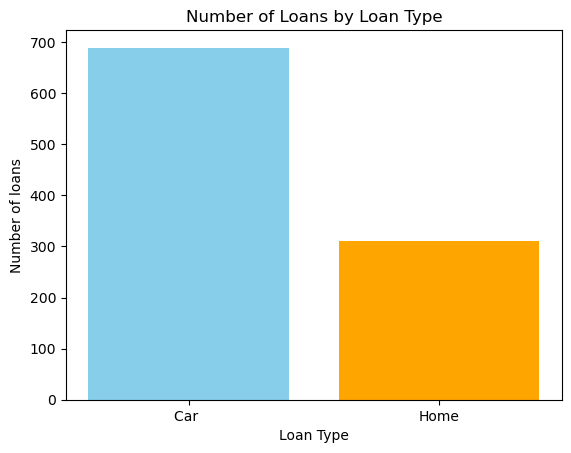

In [16]:
# Plotting 
import matplotlib.pyplot as plt

plt.bar(loan_type_counts.index, loan_type_counts.values, color = ['skyblue', 'orange'])
plt.title("Number of Loans by Loan Type")
plt.xlabel("Loan Type")
plt.ylabel("Number of loans")
plt.show()

The bar chart reveals that Car loans are significantly more common (689 loans) compared to Home loans (311 loans).

This insight could indicate a higher demand for car financing, or perhaps the bank focuses more on this loan type.


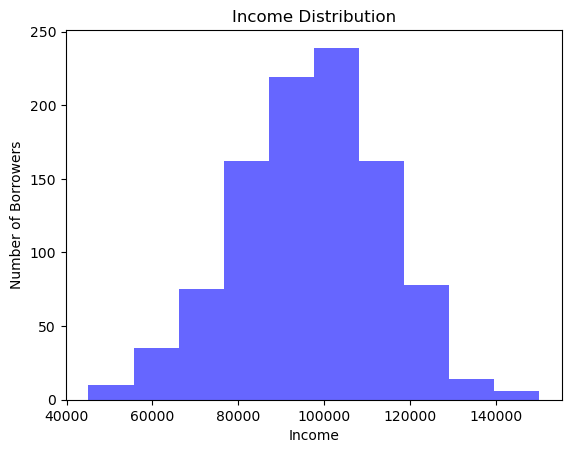

In [17]:
# This code creates and displays a histogram to visualize the distribution 
# of borrower incomes from the borrower_info DataFrame.

plt.hist(borrower_info['Income'], bins=10, color='blue', alpha=0.6)
plt.title("Income Distribution")
plt.xlabel("Income")
plt.ylabel("Number of Borrowers")
plt.show()


This histogram shows that borrower incomes are concentrated around the middle-income range, specifically near 100,000. This highlights an opportunity to tailor loan products for this demographic, as they represent the bulk of the bank’s customer base.

The tails of the distribution (below 60,000 and above 120,000) suggest that fewer borrowers belong to lower or higher-income brackets.

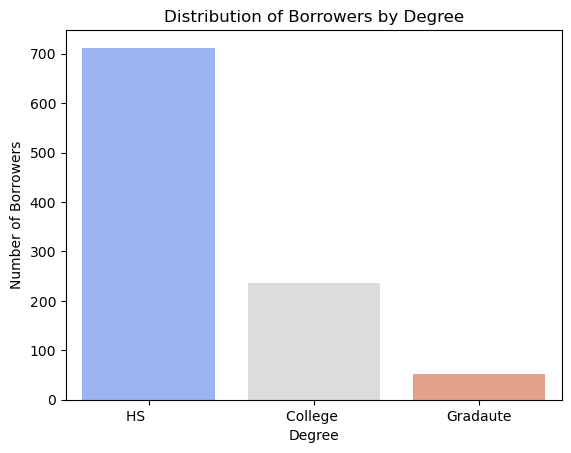

In [18]:
# Borrower Demographics
# Bar Plot: Distribution of Borrowers by Degree
# What to plot: Count of borrowers for each degree type.
import seaborn as sns
sns.countplot(x='Degree', data=borrower_info, palette="coolwarm")
plt.title("Distribution of Borrowers by Degree")
plt.xlabel("Degree")
plt.ylabel("Number of Borrowers")
plt.show()

The majority of borrowers fall under the HS (High School) category, with fewer borrowers holding college or advanced degrees.


This distribution suggests targeting high-school graduates could be critical for business expansion.

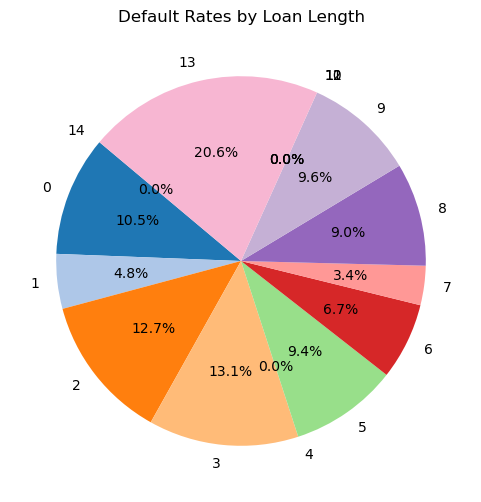

In [20]:
#  Pie Chart: Default Rates by Loan Length

# Aggregate data to calculate default rates by loan length
default_rates = loan_details.groupby('Loan_lenght')['Default'].mean()

# Plotting
plt.figure(figsize=(6,6))
plt.pie(default_rates, labels=default_rates.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title("Default Rates by Loan Length")
plt.show()

Loan Length 13 is Concerning:

Borrowers with this loan term have the highest rate of default (20.6%), so further investigation is necessary:

Are these loans poorly structured?

Do they target higher-risk borrowers?

Loan lengths like 4, 10, 11, 12, and 14 can be considered safe, with no defaults observed.